In [5]:
import os
import pyedflib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, welch

In [11]:
# Directory containing the EDF files
data_dir = '/Users/tereza/mesa/polysomnography/edfs'

# Get a sorted list of EDF files and select the first 10
edf_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.edf')])
first10_files = edf_files[:10]

# channels of interest (EEG, EKG, EMG)
# channels_keywords = ['eeg', 'ekg', 'emg']
channels_keywords = ['eeg']

EEG1 duration: 43199.0 s (12.00 hours)
EEG2 duration: 43199.0 s (12.00 hours)
EEG3 duration: 43199.0 s (12.00 hours)


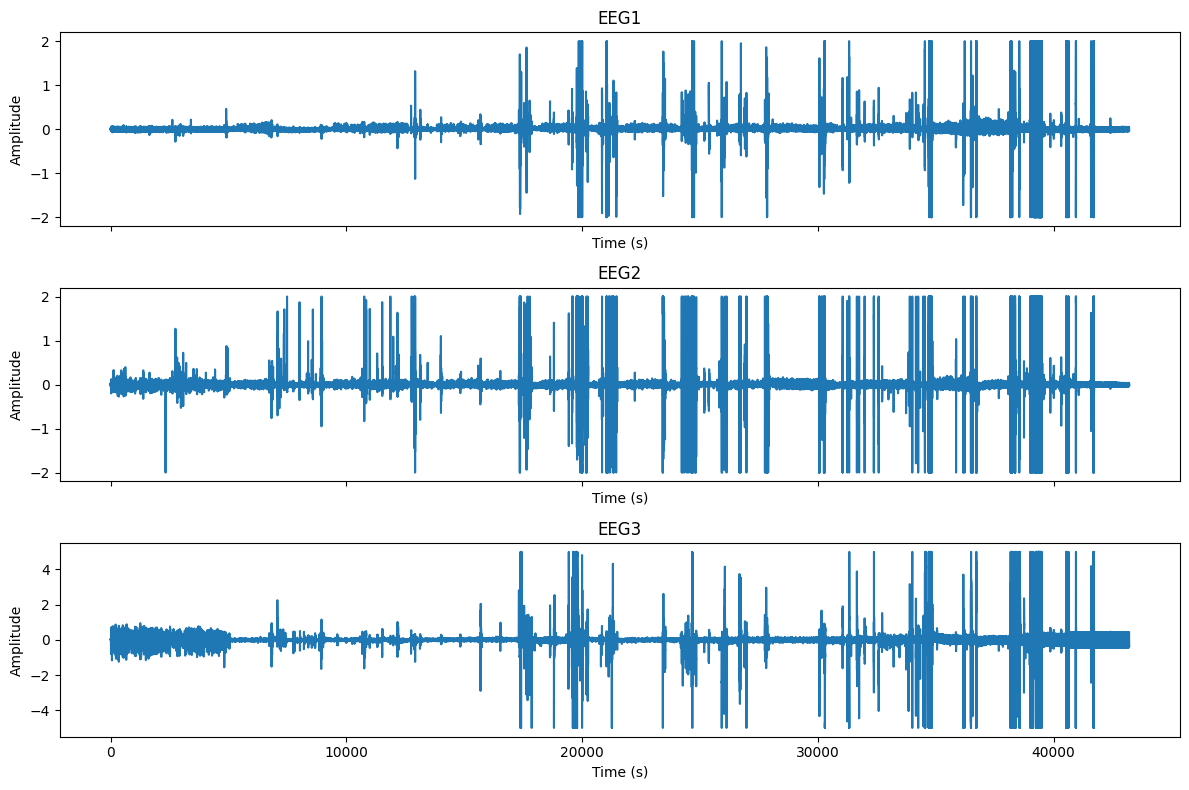

In [10]:
first_file = edf_files[0]  # first subject

file_path = os.path.join(data_dir, first_file)
edf_reader = pyedflib.EdfReader(file_path)
signal_labels = edf_reader.getSignalLabels()

eeg_channels = []
eeg_data = []
fs_list = []

# Select EEG channels that do not end with '_Off'
for i, label in enumerate(signal_labels):
    label_lower = label.lower()
    if 'eeg' in label_lower and not label_lower.endswith('_off'):
        signal = edf_reader.readSignal(i)
        fs = edf_reader.getSampleFrequency(i)
        eeg_channels.append(label)
        eeg_data.append(signal)
        fs_list.append(fs)

edf_reader.close()

# Plot each EEG channel in a separate subplot
fig, axs = plt.subplots(len(eeg_data), 1, figsize=(12, 8), sharex=True)
if len(eeg_data) == 1:
    axs = [axs]

for i, signal in enumerate(eeg_data):
    fs = fs_list[i]
    t = np.arange(len(signal)) / fs

    # Calculate total duration in seconds and hours
    duration_seconds = len(signal) / fs
    duration_hours = duration_seconds / 3600
    
    # Print duration info
    print(f"{eeg_channels[i]} duration: {duration_seconds:.1f} s ({duration_hours:.2f} hours)")
    
    axs[i].plot(t, signal)
    axs[i].set_title(eeg_channels[i])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [19]:
# def highpass_filter(signal, fs, cutoff=0.5, order=4):
#     """
#     Butterworth high-pass filter to remove slow drifts below 'cutoff' Hz.
#     """
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='high', analog=False)
#     return filtfilt(b, a, signal)

# def notch_filter(signal, fs, notch_freq=50.0, quality=30.0):
#     """
#     IIR notch filter around 'notch_freq' Hz with specified 'quality' factor.
#     """
#     nyquist = 0.5 * fs
#     w0 = notch_freq / nyquist
#     b, a = iirnotch(w0, quality)
#     return filtfilt(b, a, signal)

# filtered_data = []
# for i, raw_signal in enumerate(eeg_data):
#     fs = fs_list[i]
    
#     # 1. High-pass filter
#     hp_signal = highpass_filter(raw_signal, fs, cutoff=0.5, order=4)
    
#     # 2. Notch filter at 50 Hz (or 60 Hz if needed)
#     nf_signal = notch_filter(hp_signal, fs, notch_freq=50.0, quality=30.0)
    
#     filtered_data.append(nf_signal)

In [12]:
def highpass_filter(signal, fs, cutoff=0.5, order=4):
    """
    Butterworth high-pass filter to remove slow drifts below 'cutoff' Hz.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def auto_notch_filter(signal, fs, center_guess=50.0, search_range=1.0, quality=30.0):
    """
    Finds the actual peak near 'center_guess' ± 'search_range' in the PSD,
    and applies a notch filter at that frequency.
    
    signal:       1D numpy array of the EEG signal
    fs:           Sampling rate in Hz
    center_guess: Expected center frequency of line noise (50 or 60)
    search_range: Range (±) around center_guess to look for the actual peak
    quality:      Quality factor (Q) for iirnotch
    """
    # 1) Estimate PSD to find the actual interference frequency near center_guess
    freqs, psd = welch(signal, fs=fs, nperseg=2048)
    
    lower = center_guess - search_range
    upper = center_guess + search_range
    
    # Indices in the PSD for frequencies within [lower, upper]
    idx = np.where((freqs >= lower) & (freqs <= upper))[0]
    if len(idx) == 0:
        # No frequency bins in that range; return the original signal
        return signal
    
    # 2) Identify the frequency bin with the highest power in that band
    local_psd = psd[idx]
    peak_idx = np.argmax(local_psd)
    true_line_freq = freqs[idx[peak_idx]]
    
    # 3) Construct and apply the notch filter at the detected frequency
    nyquist = 0.5 * fs
    w0 = true_line_freq / nyquist
    b, a = iirnotch(w0, quality)
    filtered_signal = filtfilt(b, a, signal)
    
    return filtered_signal

# Now replace the old fixed-frequency notch approach with this new code
filtered_data = []
for i, raw_signal in enumerate(eeg_data):
    fs = fs_list[i]
    
    # 1. High-pass filter to remove slow drifts
    hp_signal = highpass_filter(raw_signal, fs, cutoff=0.5, order=4)
    
    # 2. Auto-notch filter around 50 Hz (adjust to 60 if needed)
    nf_signal = auto_notch_filter(hp_signal, fs, center_guess=50.0, search_range=1.0, quality=30.0)
    
    filtered_data.append(nf_signal)


Channel: EEG1
Total Power: 9.41e-02


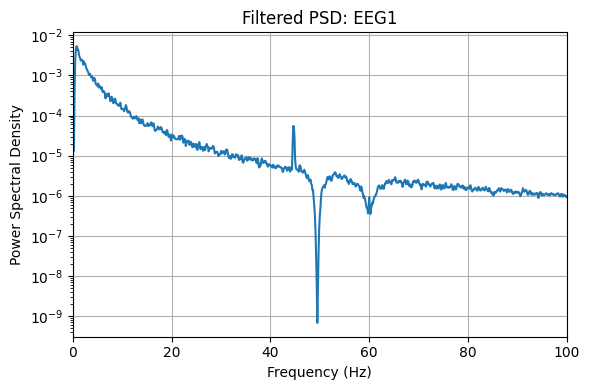

Top frequency bins by fraction of total power:
  Freq=0.75 Hz, PSD=5.38e-03, Fraction=0.0571
  Freq=0.88 Hz, PSD=5.12e-03, Fraction=0.0544
  Freq=0.62 Hz, PSD=4.44e-03, Fraction=0.0472
  Freq=1.00 Hz, PSD=4.35e-03, Fraction=0.0462
  Freq=1.12 Hz, PSD=4.33e-03, Fraction=0.0460

Channel: EEG2
Total Power: 1.36e-01


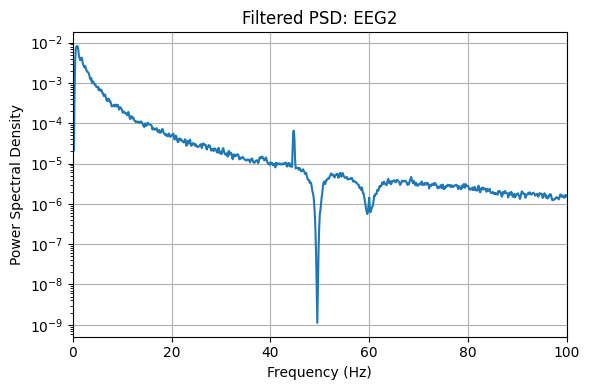

Top frequency bins by fraction of total power:
  Freq=0.88 Hz, PSD=8.17e-03, Fraction=0.0599
  Freq=0.75 Hz, PSD=8.15e-03, Fraction=0.0598
  Freq=1.00 Hz, PSD=8.05e-03, Fraction=0.0590
  Freq=0.62 Hz, PSD=7.19e-03, Fraction=0.0527
  Freq=1.12 Hz, PSD=6.44e-03, Fraction=0.0472

Channel: EEG3
Total Power: 4.36e-01


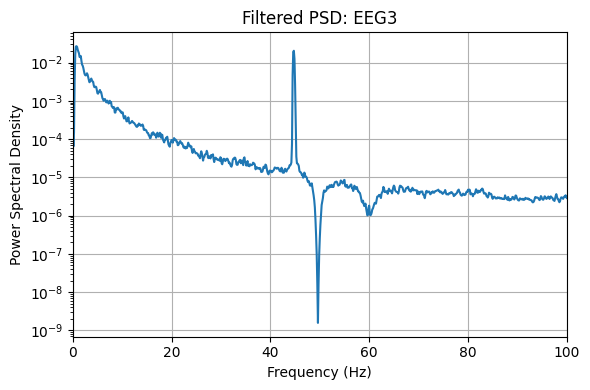

Top frequency bins by fraction of total power:
  Freq=0.75 Hz, PSD=2.68e-02, Fraction=0.0614
  Freq=0.62 Hz, PSD=2.62e-02, Fraction=0.0600
  Freq=0.88 Hz, PSD=2.55e-02, Fraction=0.0585
  Freq=1.00 Hz, PSD=2.16e-02, Fraction=0.0495
  Freq=44.75 Hz, PSD=2.03e-02, Fraction=0.0466


In [13]:
# PSD and fraction of total power for each channel
for i, signal in enumerate(filtered_data):
    fs = fs_list[i]
    freqs, psd = welch(signal, fs=fs, nperseg=2048)
    
    total_power = np.sum(psd)
    frac_power = psd / total_power  # fraction of total power at each frequency
    
    print(f"\nChannel: {eeg_channels[i]}")
    print(f"Total Power: {total_power:.2e}")
    
    # Plot the PSD
    plt.figure(figsize=(6,4))
    plt.semilogy(freqs, psd)
    plt.title(f"Filtered PSD: {eeg_channels[i]}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.xlim([0, 100])  # Often we focus on 0-100 Hz for EEG
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # which frequencies carry the most power:
    sorted_indices = np.argsort(frac_power)[::-1]
    print("Top frequency bins by fraction of total power:")
    for idx in sorted_indices[:5]:
        print(f"  Freq={freqs[idx]:.2f} Hz, PSD={psd[idx]:.2e}, Fraction={frac_power[idx]:.4f}")

CHECKS AND STUFF

In [22]:
def detect_dc_offset_duration(signal, fs, threshold_multiplier=1.0, window_seconds=1.0):
    """
    Returns an estimate (in seconds) of how long the signal remains 'offset' at the start.
    
    signal: 1D numpy array of raw EEG signal
    fs: Sampling rate (Hz)
    threshold_multiplier: Number of std devs to consider as 'offset' threshold
    window_seconds: Duration (in seconds) of consecutive samples that must be within threshold
                    for us to decide the offset has ended
    """
    # Compute a "long-term" mean and std using a stable (later) segment of the signal
    # Here, for simplicity, we use the entire signal. You can pick a later portion.
    global_mean = np.mean(signal)
    global_std = np.std(signal)
    
    # Define the threshold
    threshold = threshold_multiplier * global_std
    
    # Convert window duration to number of samples
    window_size = int(window_seconds * fs)
    
    # Scan from the beginning until we find a window of samples 
    # whose absolute difference from the global_mean is <= threshold
    # for the entire window.
    for start_idx in range(len(signal) - window_size):
        window = signal[start_idx : start_idx + window_size]
        if np.all(np.abs(window - global_mean) <= threshold):
            # The offset ends at the start of this window
            return start_idx / fs
    
    # If we never find a stable window, return the entire duration
    return len(signal) / fs


offset_duration_s = detect_dc_offset_duration(signal, fs)

print(f"Estimated offset duration: {offset_duration_s:.2f} seconds")


Estimated offset duration: 0.00 seconds


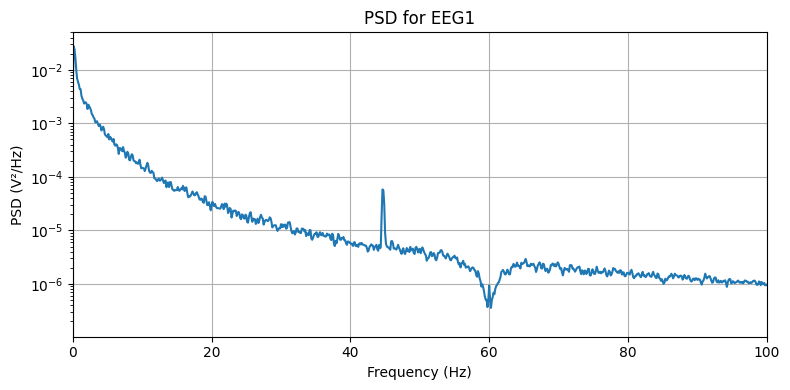

EEG1:
  Average power around 50 Hz: 5.88e-06
  Average power around 60 Hz: 2.35e-06



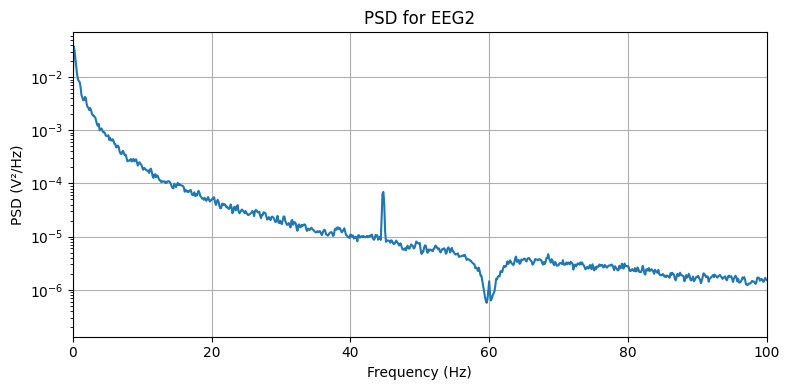

EEG2:
  Average power around 50 Hz: 1.05e-05
  Average power around 60 Hz: 3.60e-06



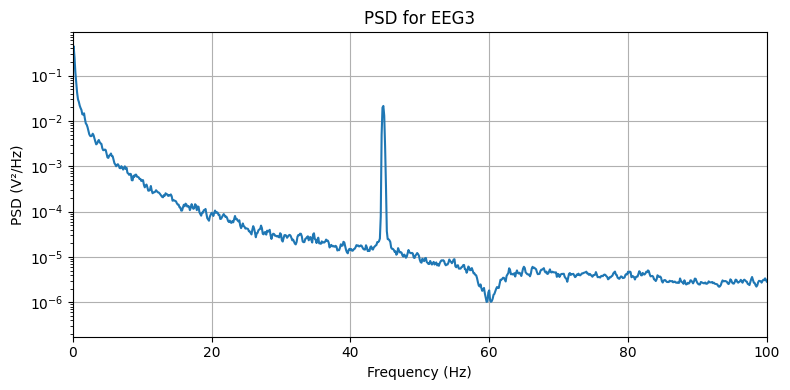

EEG3:
  Average power around 50 Hz: 1.58e-05
  Average power around 60 Hz: 4.58e-06



In [23]:
# checking for power line noise

# For each EEG channel, compute and plot the PSD and check power line noise
for i, signal in enumerate(eeg_data):
    fs = fs_list[i]
    freqs, psd = welch(signal, fs=fs, nperseg=2048)
    
    # Plot PSD focusing on 0-100 Hz
    plt.figure(figsize=(8, 4))
    plt.semilogy(freqs, psd)
    plt.title(f"PSD for {eeg_channels[i]}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V²/Hz)")
    plt.xlim([0, 100])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Define a narrow band around 50 Hz and 60 Hz (+/-1 Hz)
    band_width = 1.0
    idx_50 = np.where((freqs >= 40 - band_width) & (freqs <= 40 + band_width))
    idx_60 = np.where((freqs >= 65 - band_width) & (freqs <= 65 + band_width))
    
    avg_power_50 = np.mean(psd[idx_50])
    avg_power_60 = np.mean(psd[idx_60])
    
    print(f"{eeg_channels[i]}:")
    print(f"  Average power around 50 Hz: {avg_power_50:.2e}")
    print(f"  Average power around 60 Hz: {avg_power_60:.2e}\n")

ALL SUBJECTS

In [24]:
# def highpass_filter(signal, fs, cutoff=0.5, order=4):
#     """
#     Butterworth high-pass filter to remove slow drifts below 'cutoff' Hz.
#     """
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='high', analog=False)
#     return filtfilt(b, a, signal)

# def auto_notch_filter(signal, fs, center_guess=50.0, search_range=1.0, quality=30.0):
#     """
#     Finds the actual peak near 'center_guess' ± 'search_range' in the PSD,
#     and applies a notch filter at that frequency.
#     Prints the identified notch frequency.
#     """
#     freqs, psd = welch(signal, fs=fs, nperseg=2048)
#     lower = center_guess - search_range
#     upper = center_guess + search_range
#     idx = np.where((freqs >= lower) & (freqs <= upper))[0]
#     if len(idx) == 0:
#         print("No frequency bins in search range; returning original signal.")
#         return signal
#     local_psd = psd[idx]
#     peak_idx = np.argmax(local_psd)
#     true_line_freq = freqs[idx[peak_idx]]
#     print(f"Identified notch frequency: {true_line_freq:.2f} Hz")
#     nyquist = 0.5 * fs
#     w0 = true_line_freq / nyquist
#     b, a = iirnotch(w0, quality)
#     filtered_signal = filtfilt(b, a, signal)
#     return filtered_signal

# # Directory containing the EDF files
# data_dir = '/Users/tereza/mesa/polysomnography/edfs'
# edf_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.edf')])

# # Process all subjects (all EDF files)
# preprocessed_data = []
# for file in edf_files:
#     file_path = os.path.join(data_dir, file)
#     edf_reader = pyedflib.EdfReader(file_path)
#     signal_labels = edf_reader.getSignalLabels()
    
#     subject_data = {'file': file, 'channels': {}}
    
#     for i, label in enumerate(signal_labels):
#         label_lower = label.lower()
#         # Only consider EEG channels not ending with '_off'
#         if 'eeg' in label_lower and not label_lower.endswith('_off'):
#             fs = edf_reader.getSampleFrequency(i)
#             raw_signal = edf_reader.readSignal(i)
#             # Apply high-pass filter
#             hp_signal = highpass_filter(raw_signal, fs, cutoff=0.5, order=4)
#             # Apply auto-notch filter (centered near 50 Hz)
#             nf_signal = auto_notch_filter(hp_signal, fs, center_guess=50.0, search_range=1.0, quality=30.0)
#             subject_data['channels'][label] = {'signal': nf_signal, 'fs': fs}
#     edf_reader.close()
#     preprocessed_data.append(subject_data)

# print("Preprocessing complete for all subjects.")

In [4]:
def highpass_filter(signal, fs, cutoff=0.5, order=4):
    """
    Butterworth high-pass filter to remove slow drifts below 'cutoff' Hz.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def auto_notch_filter(signal, fs, center_guess=50.0, search_range=1.0, quality=30.0):
    """
    Finds the actual peak near 'center_guess' ± 'search_range' in the PSD,
    and applies a notch filter at that frequency.
    Prints the identified notch frequency.
    """
    freqs, psd = welch(signal, fs=fs, nperseg=2048)
    lower = center_guess - search_range
    upper = center_guess + search_range
    idx = np.where((freqs >= lower) & (freqs <= upper))[0]
    if len(idx) == 0:
        print("No frequency bins in search range; returning original signal.")
        return signal
    local_psd = psd[idx]
    peak_idx = np.argmax(local_psd)
    true_line_freq = freqs[idx[peak_idx]]
    print(f"Identified notch frequency: {true_line_freq:.2f} Hz")
    nyquist = 0.5 * fs
    w0 = true_line_freq / nyquist
    b, a = iirnotch(w0, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Directory containing the EDF files
data_dir = '/Users/tereza/mesa/polysomnography/edfs'
edf_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.edf')])
first10_files = edf_files[:10]  # Process only the first 10 subjects

preprocessed_data = []  # List to hold data for each subject

for file in first10_files:
    file_path = os.path.join(data_dir, file)
    edf_reader = pyedflib.EdfReader(file_path)
    signal_labels = edf_reader.getSignalLabels()
    
    subject_data = {'file': file, 'channels': {}}
    
    for i, label in enumerate(signal_labels):
        label_lower = label.lower()
        # Only consider EEG channels not ending with '_off'
        if 'eeg' in label_lower and not label_lower.endswith('_off'):
            fs = edf_reader.getSampleFrequency(i)
            raw_signal = edf_reader.readSignal(i)
            # Apply high-pass filter
            hp_signal = highpass_filter(raw_signal, fs, cutoff=0.5, order=4)
            # Apply auto-notch filter (centered near 50 Hz)
            nf_signal = auto_notch_filter(hp_signal, fs, center_guess=50.0, search_range=1.0, quality=30.0)
            subject_data['channels'][label] = {'signal': nf_signal, 'fs': fs}
    edf_reader.close()
    preprocessed_data.append(subject_data)

print("Preprocessing complete for first 10 subjects.")

Identified notch frequency: 49.50 Hz
Identified notch frequency: 49.50 Hz
Identified notch frequency: 49.62 Hz
Identified notch frequency: 50.75 Hz
Identified notch frequency: 50.75 Hz
Identified notch frequency: 50.88 Hz
Identified notch frequency: 49.12 Hz
Identified notch frequency: 49.00 Hz
Identified notch frequency: 50.50 Hz
Identified notch frequency: 51.00 Hz
Identified notch frequency: 50.75 Hz
Identified notch frequency: 50.25 Hz
Identified notch frequency: 51.00 Hz
Identified notch frequency: 49.50 Hz
Identified notch frequency: 50.75 Hz
Identified notch frequency: 49.00 Hz
Identified notch frequency: 51.00 Hz
Identified notch frequency: 51.00 Hz
Identified notch frequency: 50.25 Hz
Identified notch frequency: 49.25 Hz
Identified notch frequency: 49.62 Hz
Identified notch frequency: 49.38 Hz
Identified notch frequency: 49.25 Hz
Identified notch frequency: 49.00 Hz
Identified notch frequency: 50.88 Hz
Identified notch frequency: 50.62 Hz
Identified notch frequency: 50.50 Hz
I

In [1]:
# -----------------------------
# Plotting: First 10 Subjects, All 3 EEG Channels
# -----------------------------
num_subjects = 4
colors = plt.cm.tab10(np.linspace(0, 1, num_subjects))

# Assume that all subjects have the same EEG channel labels.
if num_subjects > 0:
    subject0 = preprocessed_data[0]
    channel_labels = sorted(subject0['channels'].keys())
else:
    channel_labels = []
num_channels = len(channel_labels)
print("Common EEG channels:", channel_labels)

# Time Domain Plot: One subplot per EEG channel, overlaying curves from first 10 subjects
fig_time, axs_time = plt.subplots(num_channels, 1, figsize=(12, 3*num_channels), sharex=True)
if num_channels == 1:
    axs_time = [axs_time]
for ch_idx, ch_label in enumerate(channel_labels):
    for subj_idx in range(num_subjects):
        subj = preprocessed_data[subj_idx]
        if ch_label in subj['channels']:
            data = subj['channels'][ch_label]['signal']
            fs = subj['channels'][ch_label]['fs']
            t = np.arange(len(data)) / fs
            axs_time[ch_idx].plot(t, data, color=colors[subj_idx], label=subj['file'] if ch_idx == 0 else "")
    axs_time[ch_idx].set_title(f"Time Domain: {ch_label}")
    axs_time[ch_idx].set_xlabel("Time (s)")
    axs_time[ch_idx].set_ylabel("Amplitude")
if num_channels > 0:
    axs_time[0].legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

# Frequency Domain Plot (PSD): One subplot per EEG channel, overlaying curves from first 10 subjects
fig_freq, axs_freq = plt.subplots(num_channels, 1, figsize=(12, 3*num_channels), sharex=True)
if num_channels == 1:
    axs_freq = [axs_freq]
for ch_idx, ch_label in enumerate(channel_labels):
    for subj_idx in range(num_subjects):
        subj = preprocessed_data[subj_idx]
        if ch_label in subj['channels']:
            data = subj['channels'][ch_label]['signal']
            fs = subj['channels'][ch_label]['fs']
            freqs, psd = welch(data, fs=fs, nperseg=2048)
            axs_freq[ch_idx].semilogy(freqs, psd, color=colors[subj_idx], 
                                       label=subj['file'] if ch_idx == 0 else "")
    axs_freq[ch_idx].set_title(f"Frequency Domain (PSD): {ch_label}")
    axs_freq[ch_idx].set_xlabel("Frequency (Hz)")
    axs_freq[ch_idx].set_ylabel("PSD (V^2/Hz)")
    axs_freq[ch_idx].set_xlim([0, 100])
if num_channels > 0:
    axs_freq[0].legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [12]:
# # Directory containing the EDF files
# data_dir = '/Users/tereza/mesa/polysomnography/edfs'

# # Get a sorted list of EDF files and select the first 10
# edf_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.edf')])
# first10_files = edf_files[:10]

# # channels of interest (EEG, EKG, EMG)
# channels_keywords = ['eeg', 'ekg', 'emg']
# # channels_keywords = ['eeg']

# for file in first10_files:
#     file_path = os.path.join(data_dir, file)
#     edf_reader = pyedflib.EdfReader(file_path)
#     signal_labels = edf_reader.getSignalLabels()
#     print(f"File: {file}")
    
#     for i, label in enumerate(signal_labels):
#         label_lower = label.lower()
#         if 'eeg' in label_lower and not label_lower.endswith('_off'):
#             sample_rate = edf_reader.getSampleFrequency(i)
#             nyquist = sample_rate / 2.0
#             print(f"Channel {label}: Sampling Rate = {sample_rate} Hz, Nyquist = {nyquist} Hz")
    
#     edf_reader.close()

# for file in first10_files:
#     file_path = os.path.join(data_dir, file)
#     edf_reader = pyedflib.EdfReader(file_path)
    
#     # Extract header information and signal labels
#     header = edf_reader.getHeader()
#     signal_labels = edf_reader.getSignalLabels()
#     print(f"File: {file}")
#     print("Header:", header)
#     print("Signal Labels:", signal_labels)
    
#     # Loop through each channel to extract signal attributes
#     for i in range(edf_reader.signals_in_file):
#         signal_header = edf_reader.getSignalHeader(i)
#         sample_freq = edf_reader.getSampleFrequency(i)
#         print(f"Channel {i} - Sample Frequency: {sample_freq}, Attributes: {signal_header}")
    
#     edf_reader.close()

streaming, incremental, stochastic, online

update estimates of the PCs -< we can't even store all the PCs

stochastic gradient coordinate descent

next steps:
do this time window boxing -> factor of 1/3 to 1/4
try to apply incremental PCA. look at how much of the signal
